# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

In this exercise, we analyze the thermodynamical properties of the noble gas argon in different phases. In doing so, we use the **microcanonical ensemble** in which the total energy $E$ of the system is considered as a constant. To modulate the interaction between two argon atoms a distance $r$ apart, we consider the well-known **Lennard-Jones potential**:

$$ V(r) = 4 \varepsilon \left ( \left (\frac{\sigma}{r} \right )^{12} - \left (\frac{\sigma}{r} \right )^{6} \right ) $$

with the two empirical constants $\varepsilon$ and $\sigma$. For argon, they take the values $\varepsilon / k_B = 120\,\mathrm{K}$ and $\sigma = 0.34\,\mathrm{nm}$. In addition, argon has an atomic mass of $m=39.948\,\mathrm{u}$. 

For the simulation of the argon ensemble, we consider $N = 108$ argon atoms in a box of volume $V = N / \rho$, where $\rho$ is the number density of argon in a certain phase. Since we are interest in bulk properties of argon, we apply periodic boundary conditions. Classically, the movement of the atoms is described by Newton's equations of motion. To solve these equations, we use the **Verlet algorithm** that computes the new position $\vec{r_i}(t+\delta t)$ of the i-th. atom based on its current $\vec{r_i}(t)$ and its old position $\vec{r_i}(t-\delta t)$ using:

$$ \vec{r_i}(t+\delta t) = 2 \vec{r_i}(t) - \vec{r_i}(t-\delta t) + \delta t^2 \vec{a_i}(t),$$

where $\delta t$ is the time difference between two successive steps of our simulation. $\vec{a_i}(t)$ is the acceleration of the i-th. atom due all other atoms in the ensemble that are in a ball with radius $r_{cut}$ centered around the i-th. particle. The application of the spherical cut-off distance makes our system isotropic. The specific choice of $r_{cut}$ depends on the phase of the argon ensemble. For the time difference, we use $\delta t = 1.076\,\mathrm{fs}$.

The simulated movement of the argon atoms allows us to derive some thermodynamical properties. Here, we are interested in the total energy $E$, the kinetic energy $K$, the potential energy $U$, the temperature $T$ and the pressure $P$. In the following, we compute these quantities for the solid, liquid and gaseous phase of argon.

### Solid Argon (@ T=96K)

Let us start with the simulation of the solid phase of argon with a number density of $\rho = 3.08 \times 10^{28}\,\mathrm{m}^{-3}$ using a cut-off radius $r_{cut} = 0.748\,\mathrm{nm}$. Since we are considering the microcanonical ensemble, we cannot specify a temperature $T$ directly. However, we can equilibrate the system roughly towards a desired temperature by rescaling the velocities of the argon atoms several times. In other words, we search for a total energy $E$ that leads to the desired temperature. The equilibration procedure for the solid phase of argon for a desired temperature of $T=96\,\mathrm{K}$ is displayed in the figure below. The first run starts from a face-centered cubic arrangement of the argon atoms in order to prevent that argon atoms are positioned very close together (which would increase the equilibration time). We compute $10000$ time steps of the system and plot the instantaneous values of the variables of interest. We take the final configuration and start another run of the system (including the velocity rescaling). After $5$ runs, the temperature oscillates around the desired temperature and we take this configuration for the following actual simulation.

Note, that the energy $E$ - unlike the other thermodynamical variables - does not show large oscillations because the total energy $E$ in the microcanonical ensemble is a fixed quantity. This reflects that the Verlert algorithm is an adequate choice for the simulation of a microcanonical ensemble of particles. 

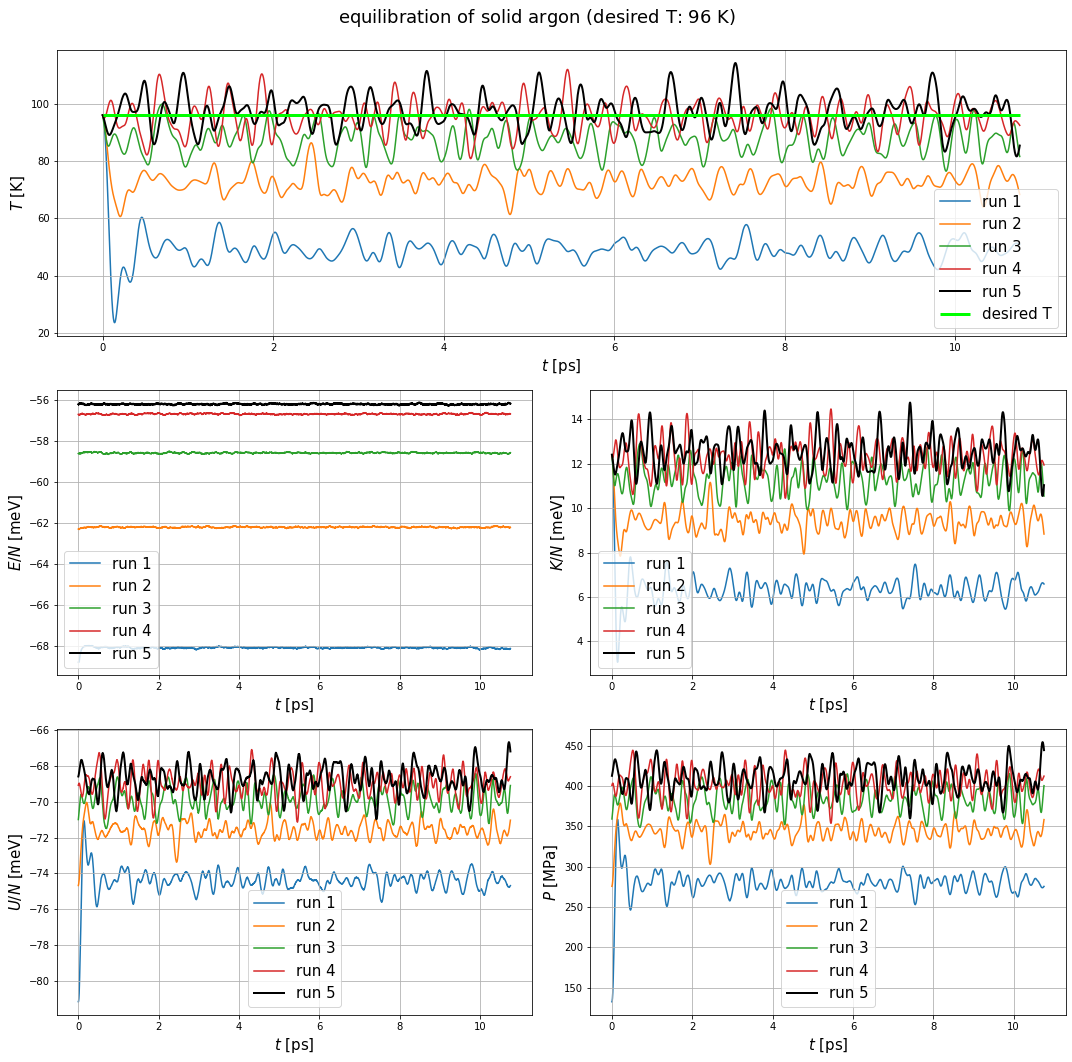

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
import os

def LJ_to_SI(vals, measure, eps, sigma, m):
    """
    Convert measures from LJ units to SI units.
    Returns:
    * temperature in K
    * energies in meV
    * pressure in MPa
    * time in ps
    """
    if measure == "temp": 
        return vals * (eps / const.k)
    if measure in ["etot", "ekin", "epot"]:
        return vals * eps / const.e * 10**3
    if measure == "pres":
        return vals * eps / sigma**3 * 10**(-6)
    if measure == "time":
        return vals * 0.0005 * sigma * np.sqrt(m / eps) * 10**12

def plot_all(directory, title, T_desired, eps, sigma, m, equi):
    """
    Plots all data.
    Use equi=True if equilibration with instantaneous values should be displayed.
    """
    
    n = int((len(os.listdir(directory)))/ 5) # number of lines per panel
    fig = plt.figure(figsize=(15, 15))
    
    measure_list = ["temp", "etot", "ekin", "epot", "pres"]
    y_label_list = ["$T$ [K]", "$E / N$ [meV]", "$K / N$ [meV]", "$U / N$ [meV]", "$P$ [MPa]"]
    index_list = [(1, 2), 3, 4, 5, 6] # where to plot
    
    for i, measure in enumerate(measure_list): # loop over measures
        ax = plt.subplot(3, 2, index_list[i])
        
        for j in range(1, n + 1): # loop over all lines in current panel
            if equi==True:
                vals = np.loadtxt(directory + "/output_" + measure + "_" + str(j) + ".dat")
                vals = LJ_to_SI(vals, measure, eps, sigma, m) # convert vals to SI
            if equi==False:
                M, vals, errors = np.loadtxt(directory + "/ave_" + measure + ".out", skiprows=1, unpack=True, delimiter=",")
                vals = LJ_to_SI(vals, measure, eps, sigma, m) # convert vals to SI
                errors = LJ_to_SI(errors, measure, eps, sigma, m) # convert errors to SI
                
            if i==0 and j==1 and equi==True: # compute timestamps in SI (same for all panels and lines)
                time = LJ_to_SI(np.arange(len(vals)), "time", eps, sigma, m)
                
            if i==0 and j==1 and equi==False: # compute timestamps in SI (same for all panels and lines)
                time = LJ_to_SI(M, "time", eps, sigma, m)

            if equi==True:
                if j < n: ax.plot(time, vals, label='run ' + str(j), zorder=j)
                else: ax.plot(time, vals, label='run ' + str(j), zorder=j, color='k', linewidth=2)
            else: 
                ax.errorbar(time, vals, errors)
            
        if measure == "temp" and equi==True: # plot desired temperature
            ax.hlines(T_desired, min(time), max(time), color='lime', linewidth=3, zorder=100, label="desired T")
            
        ax.set_xlabel("$t$ [ps]",size=15)
        ax.set_ylabel(y_label_list[i],size=15)
        ax.grid()
        if equi==True: ax.legend(fontsize=15)
            
    fig.suptitle(title + "\n", size=18)
    plt.tight_layout()
    plt.show()

# overall parameters of argon
eps = 120 * const.k # in Joule
sigma = 0.34 * 10**(-9) # in m
m = 39.948 * const.u # in kg 

# solid argon
T_desired = LJ_to_SI(0.8, "temp", eps, sigma, m)
plot_all("data/solid/equilibration", "equilibration of solid argon (desired T: $96$ K)", T_desired, eps, sigma, m, equi=True)

The next figure illustrates the results of the simulation of solid argon for a total number of $2.5 \times 10^5$ time steps. For the uncertainty estimation, we use the blocking method with $100$ blocks. The displayed quantities are progressive averages (which we do not denote explicitly). All of the measured thermodynamical variables converge. The temperature is not exactly $96\,\mathrm{K}$ as we are considering a microcanonical ensemble. For the same reason, we observe that the uncertainties on the total energy per atom $E/N$ has smaller uncertainties than the kinetic energy per atom $K/N$ or the potential energy per atom $U/N$.

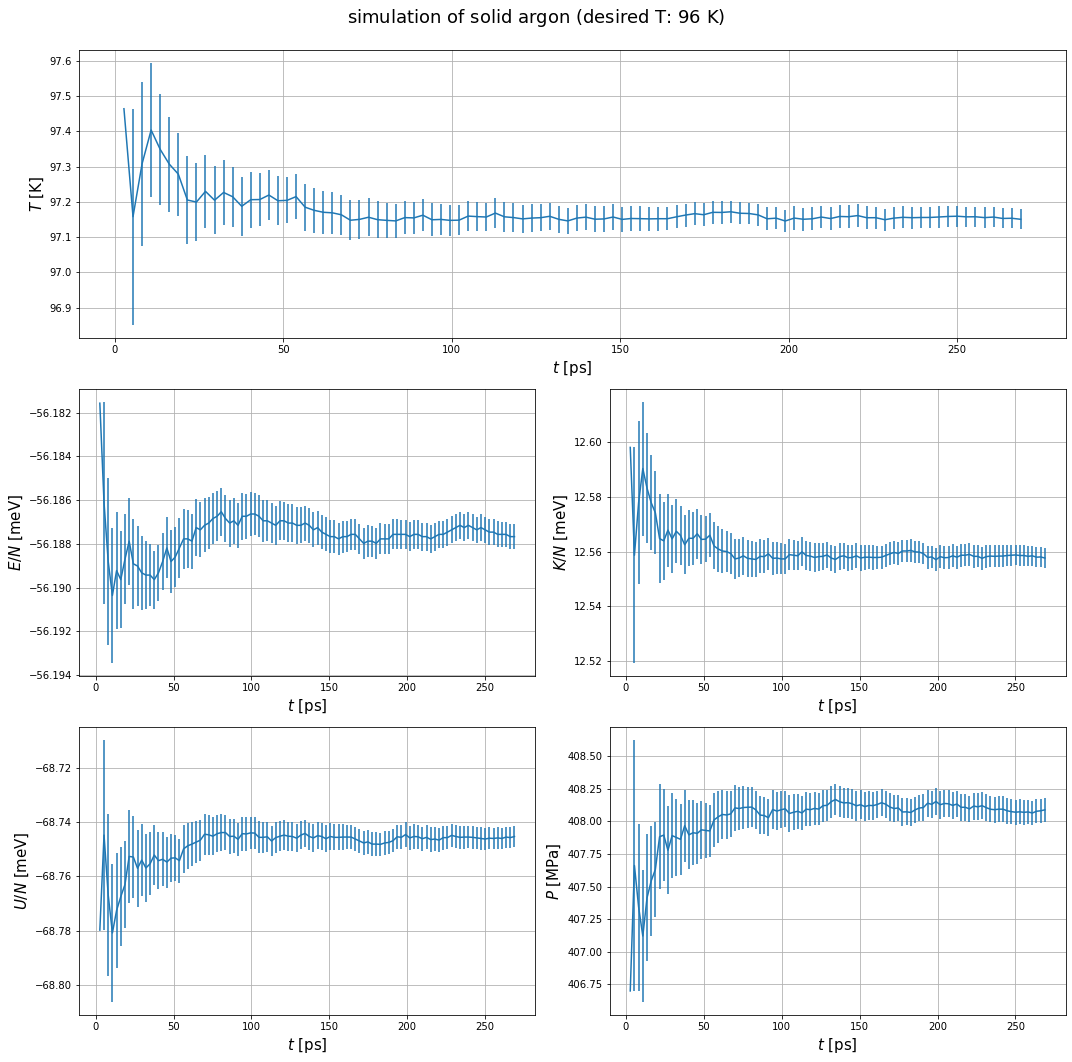

In [9]:
plot_all("data/solid", "simulation of solid argon (desired T: $96$ K)", T_desired, eps, sigma, m, equi=False)

### Liquid Argon (@ T=132K)

Now, we want to simulate liquid argon in a microcanonical ensemble using $\rho = 2.04 \times 10^{28}\,\mathrm{m}^{-3}$ and $r_{cut} = 0.85\,\mathrm{nm}$ with a desired temperature of $132\,\mathrm{K}$. The equilibration procedure is displayed in the figure below. Again, we start from a fcc configuration. This time we use $10$ runs consisting of $10000$ Monte Carlo steps to reach the desired temperature and to equilibrate the system.

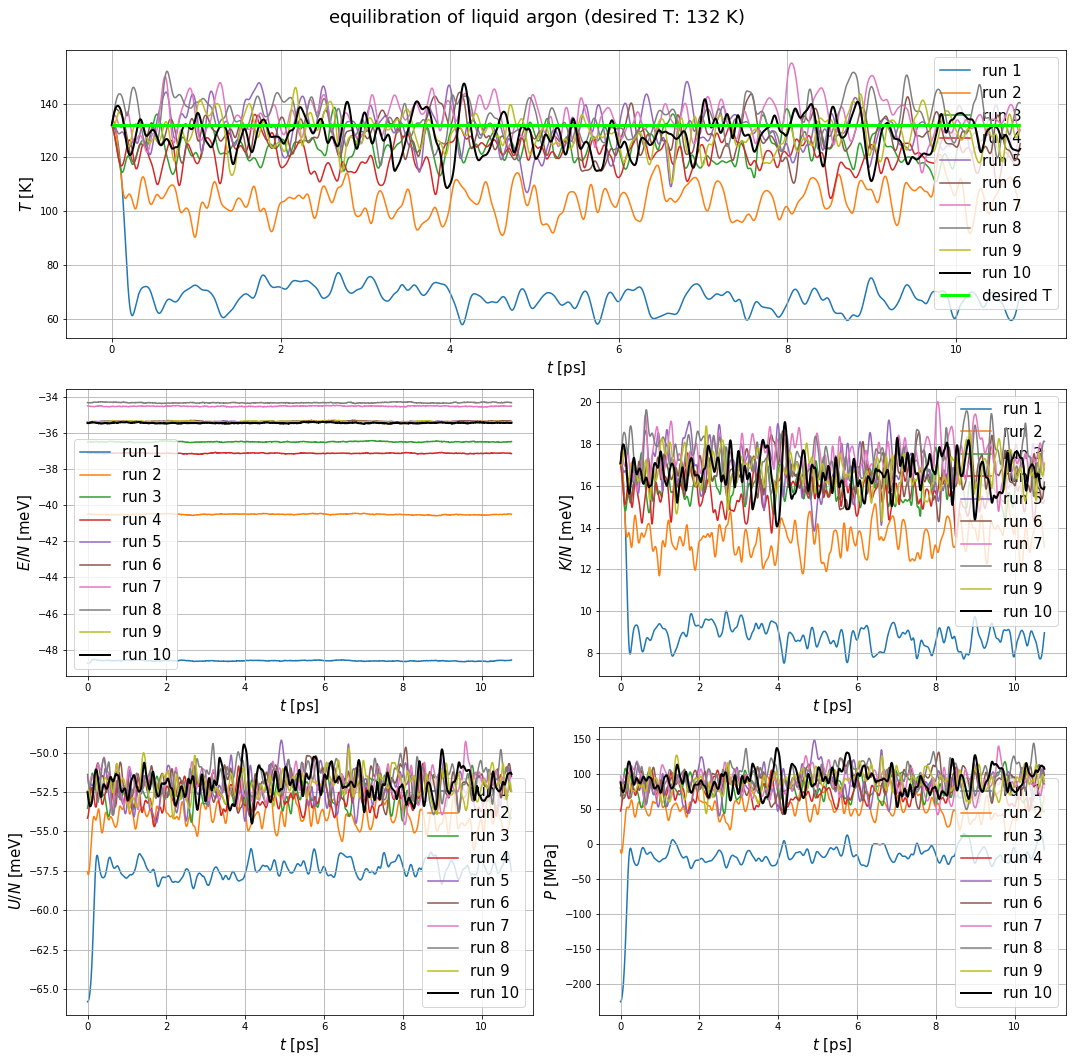

In [10]:
T_desired = LJ_to_SI(1.1, "temp", eps, sigma, m)
plot_all("data/liquid/equilibration", "equilibration of liquid argon (desired T: $132$ K)", T_desired, eps, sigma, m, equi=True)

The next figure shows the results of the simulation of liquid argon in a mircocanonical ensemble.

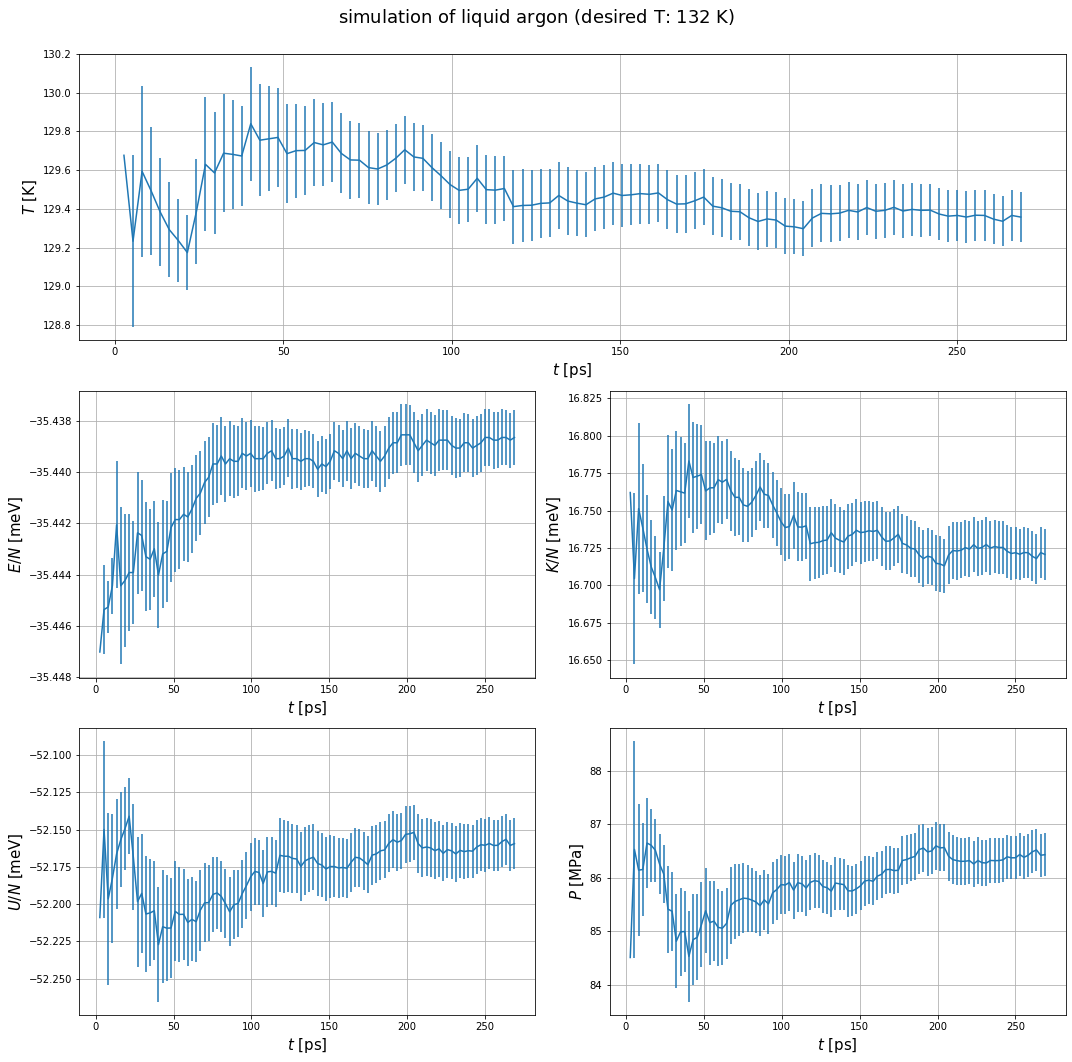

In [11]:
plot_all("data/liquid", "simulation of liquid argon (desired T: $132$ K)", T_desired, eps, sigma, m, equi=False)

### Gaseous Argon (@ T=144K)

Finally, we simulate gaseous argon using $\rho = 1.27 \times 10^{27}\,\mathrm{m}^{-3}$ and $r_{cut} = 1.7\,\mathrm{nm}$ with a desired temperature of $144\,\mathrm{K}$. The figure below illustrates the equilibration procedure starting from a fcc configuration. Again, we use $10$ runs to find the desired temperature. However, this time, instead of $10000$ steps per run, we use $20000$ steps because the temperature oscillates much more than for the solid or the liquid case. One reason for this behaviour is that the equilibrium configuration of argon gas is far more away from the fcc configuration than for the liquid argon above.

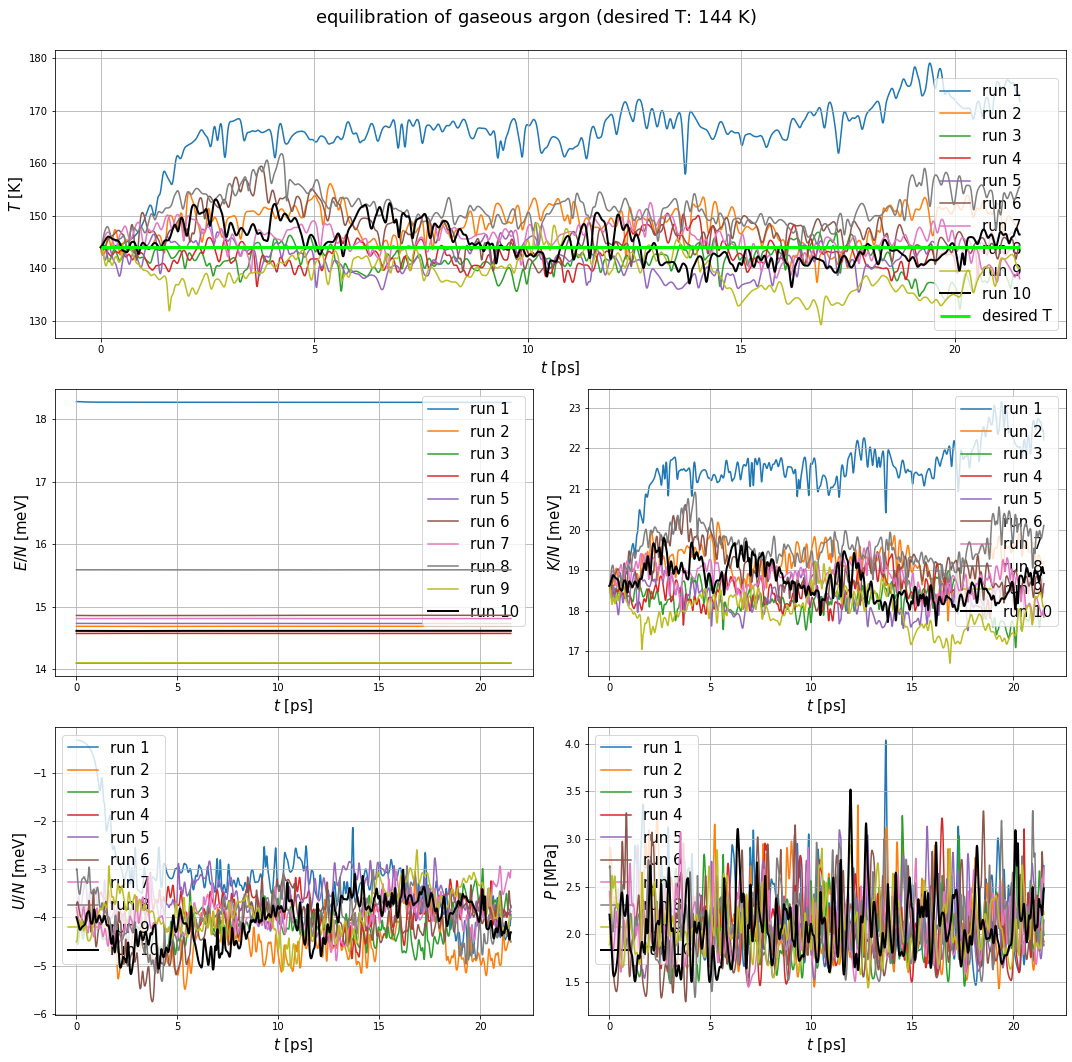

In [12]:
T_desired = LJ_to_SI(1.2, "temp", eps, sigma, m)
plot_all("data/gaseous/equilibration", "equilibration of gaseous argon (desired T: $144$ K)", T_desired, eps, sigma, m, equi=True)

In the last figure below, we plot the simulation results for gaseous argon.

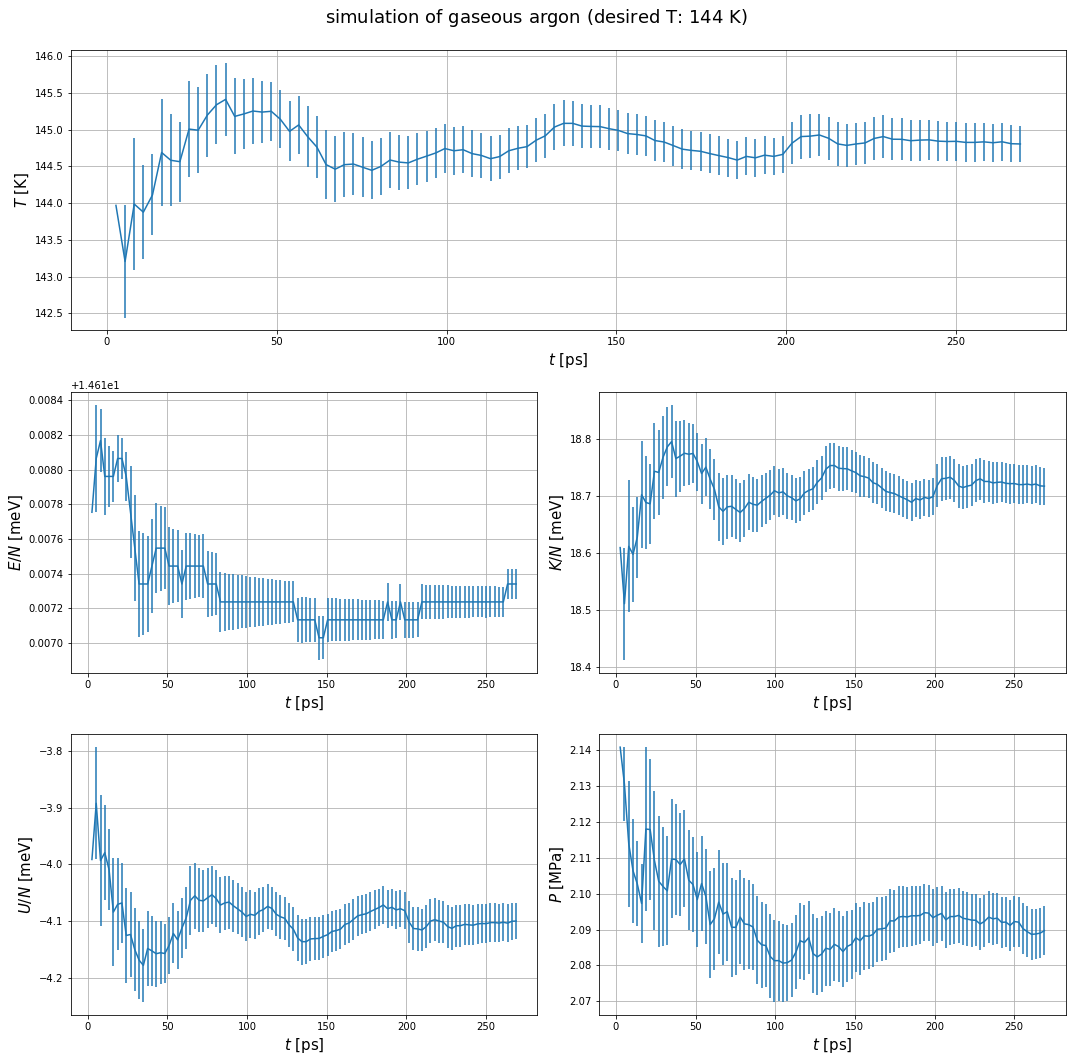

In [2]:
plot_all("data/gaseous", "simulation of gaseous argon (desired T: $144$ K)", T_desired, eps, sigma, m, equi=False)